### Importing the libraries required for web scraping

In [1]:
from bs4 import BeautifulSoup
import lxml
import requests
import pandas as pd
import re

### Scraping the website and extracting the content

In [2]:
base_url = 'https://www.trustpilot.com/review/hostinger.com?page={}'

review_star = []
review_heading = []
reviewer_country = []
dates = []

for page in range(1,120):
    page_url = base_url.format(page)
    request = requests.get(page_url)
    soup = BeautifulSoup(request.text,'lxml')
    
    reviews_star = soup.findAll('div',{'class':'star-rating star-rating--medium'})
    reviews_heading = soup.findAll('h2',{'class':'review-content__title'})
    review_dates = soup.findAll('div',{'class':'review-content-header__dates'})
    
    for i in range(0,len(reviews_star)):
        review_star.append(reviews_star[i].select('img')[0]['alt'])
        review_heading.append(reviews_heading[i].a.text)
        dates.append(((re.search(r'\d{4}-\d{2}-\d{2}',str(review_dates[i].select('script')[0]))).group()))

### Converting the scraped content to a dataframe 

In [3]:
df = pd.DataFrame({'Stars':review_star,'Review':review_heading,'Date':dates})

In [4]:
df.head()

,Stars,Review,Date
0,5 stars: Excellent,\n Truly great\n ...,2021-03-20
1,5 stars: Excellent,\n Very nice support if...,2021-03-20
2,5 stars: Excellent,\n Got What I Wanted Pr...,2021-03-19
3,5 stars: Excellent,\n Effecient\n ...,2021-03-19
4,5 stars: Excellent,\n Easy to use platform...,2021-03-18


### Preprocessing the Dataframe

In [5]:
# extracting only the number of stars 
df['Stars'] = df['Stars'].apply(lambda x: int((re.search(r'\d',x)).group()) )

# removing the extra spaces and lines
df['Review'] = df['Review'].apply(lambda x: x.replace("\n",'',2)).apply(lambda x: x.replace('  ',''))
# converting upper case to lower case
df['Review'] = df['Review'].str.lower().str.split()
# checking whether the value is a word or not 
df['Review']=df['Review'].apply(lambda x: [word for word in x if word.isalpha()])
df['Review']=[" ".join(review) for review in df['Review'].values]

import datetime
df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').date())

# dropping the duplicate rows
df = df.drop_duplicates()

In [6]:
print('The number of entry in the dataframe is {}'.format(df.shape))

The number of entry in the dataframe is (2241, 3)


In [7]:
df.head(5)

,Stars,Review,Date
0,5,truly great,2021-03-20
1,5,very nice support if i can rate her,2021-03-20
2,5,got what i wanted precisely,2021-03-19
3,5,effecient,2021-03-19
4,5,easy to use friendly inexpensive hosting service,2021-03-18


In [8]:
# checking for null values
df.isnull().any()

Stars     False
Review    False
Date      False
dtype: bool

In [9]:
# counting unique values
df['Stars'].value_counts()

5    1885
1     176
4     128
2      28
3      24
Name: Stars, dtype: int64

### Importing libraries required for generating WordCloud

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [11]:
stopwords = set(STOPWORDS)

### Defining a function for generating Wordcloud

In [12]:
def generate_wordcloud(n):
    # creating separate dataframe for each star value
    dataframe = df.loc[df['Stars']== n ,:].reset_index().drop(columns='index')
    
    # creating the words 
    words = ''
    for val in dataframe.Review:
        tokens = val.split()
        words += ' '.join(tokens)+' '
        
    # generating the word cloud
    wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)

    # plotting the wordcloud image
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

### Generating WordCloud using the function defined

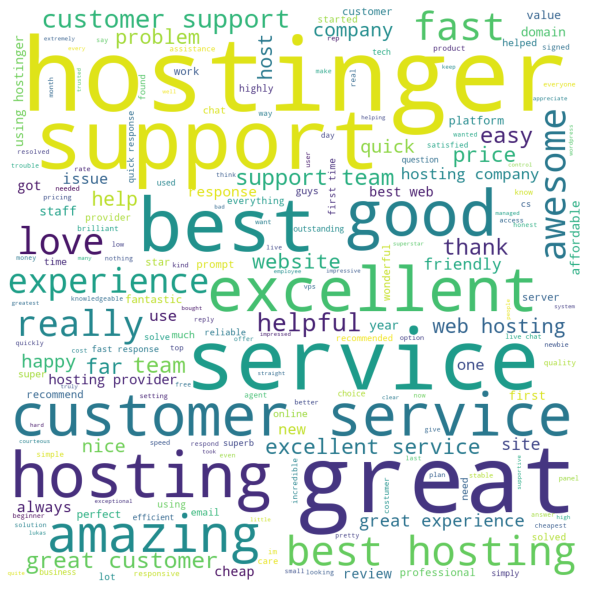

In [13]:
generate_wordcloud(5)

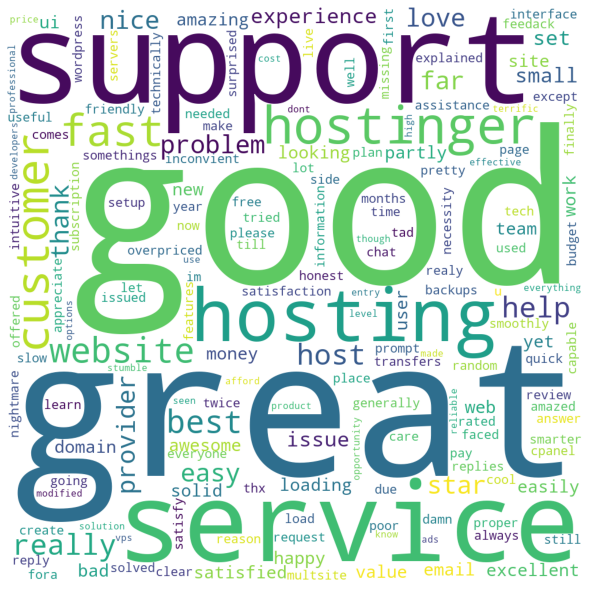

In [19]:
generate_wordcloud(4)

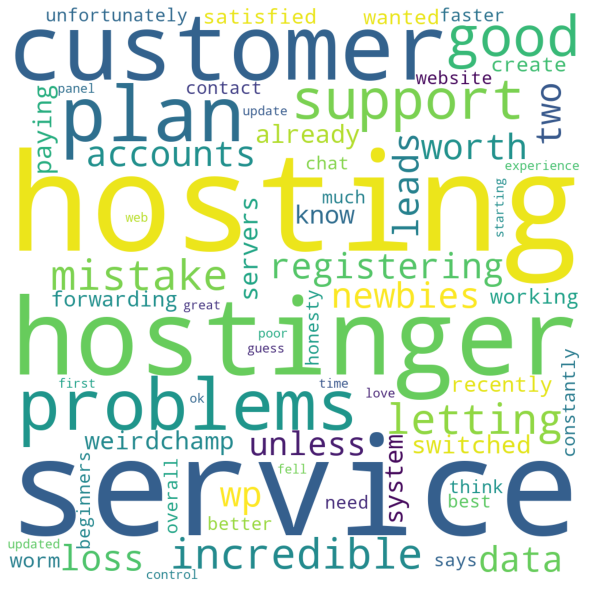

In [20]:
generate_wordcloud(3)

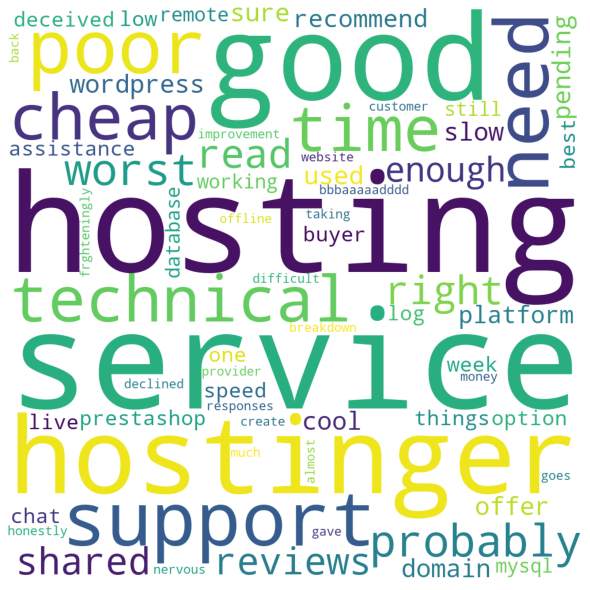

In [21]:
generate_wordcloud(2)

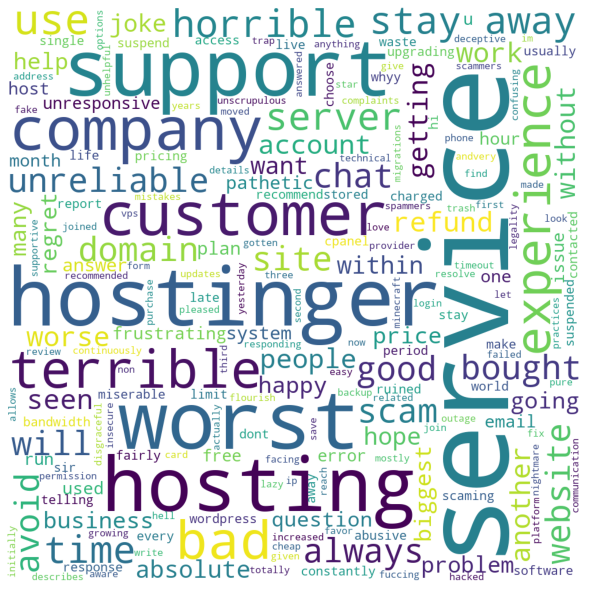

In [22]:
generate_wordcloud(1)

In [14]:
import seaborn as sns

In [15]:
df['year'] = df['Date'].apply(lambda x:x.year)

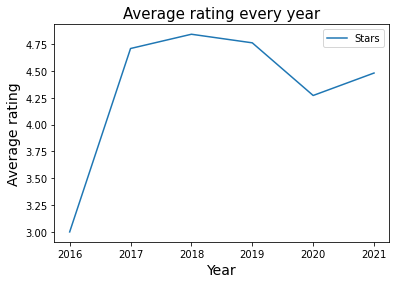

In [16]:
df_year = df.groupby('year').mean()
df_year.plot()
plt.title('Average rating every year',fontsize=15)
plt.xlabel('Year',fontsize=14)
plt.ylabel('Average rating',fontsize=14)
plt.show()

<Figure size 864x432 with 0 Axes>

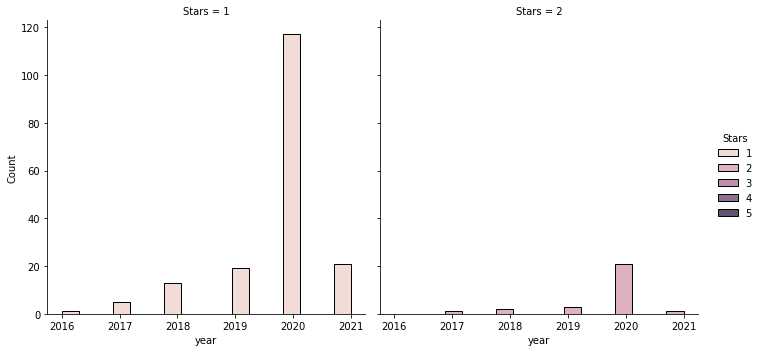

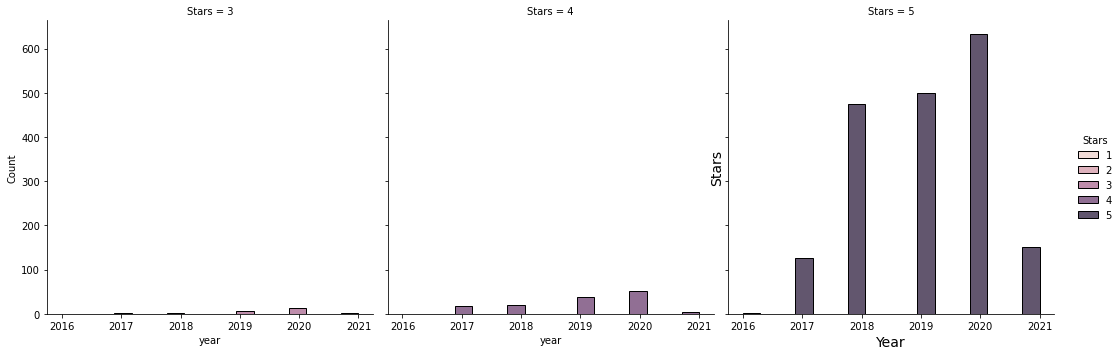

In [17]:
plt.figure(figsize=(12,6))
sns.displot(x='year',hue='Stars',data=df,multiple='dodge',col='Stars',col_order=(1,2))
sns.displot(x='year',hue='Stars',data=df,multiple='dodge',col='Stars',col_order=(3,4,5) )
plt.xlabel('Year',fontsize=14)
plt.ylabel('Stars',fontsize=14)
plt.show()